In [105]:
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
import matplotlib
import matplotlib.pyplot as plt
import itertools
import heapq
import math

import pdb
import numpy as np
from tables import *
import gcp.bigquery as bq
import gcp.storage as storage
try:
  import cPickle as pickle
except:
  import pickle
FIELDS_PICKLE = 'fields-4.pkl'
NEW_FIELDS_PICKLE = 'fields-7.pkl'
DATAFILE_PATH = 'xjk_pytable.h5'
NEW_DATAFILE_PATH = 'xjk_pytable-7.h5'
RFECV_PATH = 'rfecv1.pkl'
SELECTKBEST_PATH = 'kbest.pkl'

seed = 13
np.random.seed(seed)

fields = pickle.load(open(FIELDS_PICKLE, "r") )
fields_original = fields[:]
features = fields[1:]

# Use this instead of len(features) since this variable can change
# e.g. when one hot encoding is used and/or new features are added.
n_features = len(features)

print "Number of features: {}".format(len(features))
print "Fields:"
for a, b in enumerate(fields):
  print '{}. {}'.format(a, b)
weather_field_ids = [3, 4, 5, 18, 19, 20, 21, 22, 23]


Number of features: 163
Fields:
0. gap
1. timeofday_slot
2. day_in_week
3. weather_1_slots_ago
4. weather_2_slots_ago
5. weather_3_slots_ago
6. tj_level1_1_slots_ago
7. tj_level2_1_slots_ago
8. tj_level3_1_slots_ago
9. tj_level4_1_slots_ago
10. tj_level1_2_slots_ago
11. tj_level2_2_slots_ago
12. tj_level3_2_slots_ago
13. tj_level4_2_slots_ago
14. tj_level1_3_slots_ago
15. tj_level2_3_slots_ago
16. tj_level3_3_slots_ago
17. tj_level4_3_slots_ago
18. temperature_1_slots_ago
19. pm25_1_slots_ago
20. temperature_2_slots_ago
21. pm25_2_slots_ago
22. temperature_3_slots_ago
23. pm25_3_slots_ago
24. gap_1_slots_ago
25. sum_price_1_slots_ago
26. gap_2_slots_ago
27. sum_price_2_slots_ago
28. gap_3_slots_ago
29. sum_price_3_slots_ago
30. f1
31. f11
32. f11_1
33. f11_2
34. f11_3
35. f11_4
36. f11_5
37. f11_6
38. f11_7
39. f11_8
40. f13_4
41. f13_8
42. f14
43. f14_1
44. f14_10
45. f14_2
46. f14_3
47. f14_6
48. f14_8
49. f15
50. f15_1
51. f15_2
52. f15_3
53. f15_4
54. f15_6
55. f15_7
56. f15_8
57. 

# Overview
In this section, we will do feature selection to choose the best features.

# Load Dataset

In [93]:
fileh1 = open_file(DATAFILE_PATH, mode = 'r')

object = fileh1.get_node('/train', 'gaps')
object_array_data = object.read()
fileh1.close()

# Convert to vectorized array that we can use in further processing.
all_data = np.zeros((object_array_data.shape[0], len(fields)))
print 'there are {} rows'.format(object_array_data.shape[0])
for rcounter, row in enumerate(object_array_data):
  for fcounter, field in enumerate(fields):
    all_data[rcounter, fcounter] = row[field]
  if rcounter % 5000 == 0:
    print 'processed {} rows'.format(rcounter)
all_data_original = np.copy(all_data)

there are 102592 rows
processed 0 rows
processed 5000 rows
processed 10000 rows
processed 15000 rows
processed 20000 rows
processed 25000 rows
processed 30000 rows
processed 35000 rows
processed 40000 rows
processed 45000 rows
processed 50000 rows
processed 55000 rows
processed 60000 rows
processed 65000 rows
processed 70000 rows
processed 75000 rows
processed 80000 rows
processed 85000 rows
processed 90000 rows
processed 95000 rows
processed 100000 rows


# Preprocess Missing Data
Preprocess missing data according to previous investigation.

In [94]:
all_data = np.copy(all_data_original)
fields = fields_original[:]
print "Shape of all data before: {}".format(all_data.shape)

# Remove weather features
fields = np.delete(fields, weather_field_ids, 0).tolist()
features = fields[1:]
n_features = len(features)
print "Number of features: {}".format(len(features))
print "Features:"
print features
all_data = np.delete(all_data, weather_field_ids, 1)

# Replace rest of data with 0    
all_data[np.isnan(all_data)] = 0

print "Shape of all data after: {}".format(all_data.shape)

all_data_preprocessed = np.copy(all_data)

Shape of all data before: (102592, 164)
Number of features: 154
Features:
['timeofday_slot', 'day_in_week', 'tj_level1_1_slots_ago', 'tj_level2_1_slots_ago', 'tj_level3_1_slots_ago', 'tj_level4_1_slots_ago', 'tj_level1_2_slots_ago', 'tj_level2_2_slots_ago', 'tj_level3_2_slots_ago', 'tj_level4_2_slots_ago', 'tj_level1_3_slots_ago', 'tj_level2_3_slots_ago', 'tj_level3_3_slots_ago', 'tj_level4_3_slots_ago', 'gap_1_slots_ago', 'sum_price_1_slots_ago', 'gap_2_slots_ago', 'sum_price_2_slots_ago', 'gap_3_slots_ago', 'sum_price_3_slots_ago', 'f1', 'f11', 'f11_1', 'f11_2', 'f11_3', 'f11_4', 'f11_5', 'f11_6', 'f11_7', 'f11_8', 'f13_4', 'f13_8', 'f14', 'f14_1', 'f14_10', 'f14_2', 'f14_3', 'f14_6', 'f14_8', 'f15', 'f15_1', 'f15_2', 'f15_3', 'f15_4', 'f15_6', 'f15_7', 'f15_8', 'f16', 'f16_1', 'f16_10', 'f16_11', 'f16_12', 'f16_3', 'f16_4', 'f16_6', 'f17', 'f17_2', 'f17_3', 'f17_4', 'f17_5', 'f19', 'f19_1', 'f19_2', 'f19_3', 'f19_4', 'f1_1', 'f1_10', 'f1_11', 'f1_2', 'f1_3', 'f1_4', 'f1_5', 'f1_6', 

# One Hot Encoding
This time we will do a more complete one hot encoding. After the encoding is done, update the feature list as well, and create a datafile for it.

In [95]:
all_data = np.copy(all_data_preprocessed)
features = fields[1:]
categorical_features = [0, 1]
data = all_data[:,1:]
targets = all_data[:,0]
one_hot = OneHotEncoder(categorical_features=categorical_features, sparse=False,
                        n_values=[145, 7])
data = one_hot.fit_transform(data)
print "n values: {}".format(one_hot.n_values_)
print "feature indices: {}".format(one_hot.feature_indices_)
all_data_one_hot = np.append(np.array([targets]).T, data, axis=1)

# Create new set of fields. After doing one-hot, all original fields are placed
# to the right, which was why we use fields instead of features, as with the former
# the gap table wouldn't be at the first position anymore.
new_fields = ['gap']
# n_fields = arange(sum(one_hot.n_values_))
for id, num in enumerate(one_hot.n_values_):
  old_feature_id = categorical_features[id]
  new_fields += ['{}_{}'.format(features[old_feature_id], i) for i in np.arange(num)]
new_fields += np.delete(features, categorical_features, 0).tolist()
features = new_fields[1:]
features_one_hot = new_fields[1:]
n_features = len(features)
print "Number of features: {}".format(n_features)
print "Fields:"
for a, b in enumerate(new_fields):
  print '{}. {}'.format(a, b)

n values: [145   7]
feature indices: [  0 145 152]
Number of features: 304
Fields:
0. gap
1. timeofday_slot_0
2. timeofday_slot_1
3. timeofday_slot_2
4. timeofday_slot_3
5. timeofday_slot_4
6. timeofday_slot_5
7. timeofday_slot_6
8. timeofday_slot_7
9. timeofday_slot_8
10. timeofday_slot_9
11. timeofday_slot_10
12. timeofday_slot_11
13. timeofday_slot_12
14. timeofday_slot_13
15. timeofday_slot_14
16. timeofday_slot_15
17. timeofday_slot_16
18. timeofday_slot_17
19. timeofday_slot_18
20. timeofday_slot_19
21. timeofday_slot_20
22. timeofday_slot_21
23. timeofday_slot_22
24. timeofday_slot_23
25. timeofday_slot_24
26. timeofday_slot_25
27. timeofday_slot_26
28. timeofday_slot_27
29. timeofday_slot_28
30. timeofday_slot_29
31. timeofday_slot_30
32. timeofday_slot_31
33. timeofday_slot_32
34. timeofday_slot_33
35. timeofday_slot_34
36. timeofday_slot_35
37. timeofday_slot_36
38. timeofday_slot_37
39. timeofday_slot_38
40. timeofday_slot_39
41. timeofday_slot_40
42. timeofday_slot_41
43. t

In [96]:
# Store list of fields in a Pickle object so we don't have to rewrite everything.
try:
  import cPickle as pickle
except:
  import pickle

pickle.dump(new_fields, open(NEW_FIELDS_PICKLE, "w") )

# RFECV

In [97]:
def mape(y, predictions):
  if len(y.shape) == 1:
    y = np.asmatrix(y)
  if len(predictions.shape) == 1:
    predictions = np.asmatrix(predictions)
  y = y.astype(float)
  predictions = predictions.astype(float)
  return np.mean(np.absolute((y-predictions)/y))
mape_scorer = make_scorer(mape, greater_is_better=False)

In [109]:
OVERWRITE_RFECV = False
data = all_data_one_hot[:,1:]
targets = all_data_one_hot[:,0]
if os.path.isfile(RFECV_PATH) and OVERWRITE_RFECV == False:
  rfecv = pickle.load(open(RFECV_PATH, "r"))
else:
  rfecv = RFECV(LinearRegression(), scoring=mape_scorer, verbose=3, cv=10)
  rfecv.fit(data, targets)
  pickle.dump(rfecv, open(RFECV_PATH, "w") )

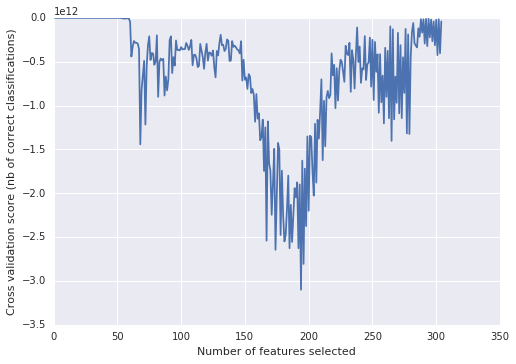

In [110]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
_ = plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [111]:
print "Optimal number of features: {}".format(rfecv.n_features_)
features_selected_rfecv = list(itertools.compress(features_one_hot, rfecv.get_support()))
print "Features selected: {}".format(features_selected_rfecv)

Optimal number of features: 1
Features selected: ['day_in_week_6']


This does not look right at all! I wonder what happened and how to correct this.

In [104]:
# This line lists features, but ordered by id
features_selected_rfecv = list(itertools.compress(features_one_hot, kbest.get_support()))

scores = heapq.nlargest(len(features_one_hot), rfecv.grid_scores_)
indexes = heapq.nlargest(len(features_one_hot), xrange(len(rfecv.grid_scores_)), key=rfecv.grid_scores_.__getitem__)
new_indexes = [x for x in indexes] 
features_selected_disp = list(np.array(features_one_hot)[new_indexes])

for id, feature in enumerate(features_selected_disp):
  if not math.isnan(scores[id]):
    print "{}. {}: {}".format(id, feature, scores[id])

0. timeofday_slot_0: -3.29770546964
1. timeofday_slot_1: -3.50108071609
2. timeofday_slot_2: -3.63882847752
3. timeofday_slot_3: -3.99345046857
4. timeofday_slot_8: -4.04671968915
5. timeofday_slot_6: -4.07483191779
6. timeofday_slot_7: -4.15038353748
7. timeofday_slot_9: -4.26992560887
8. timeofday_slot_10: -4.41114730696
9. timeofday_slot_4: -4.53584872924
10. timeofday_slot_19: -4.57383911862
11. timeofday_slot_17: -4.62759480188
12. timeofday_slot_16: -4.70201505262
13. timeofday_slot_18: -4.73555949151
14. timeofday_slot_5: -4.77674402021
15. timeofday_slot_11: -4.81922886678
16. timeofday_slot_15: -4.8254652042
17. timeofday_slot_20: -4.90764857444
18. timeofday_slot_13: -5.010229834
19. timeofday_slot_12: -5.05423725394
20. timeofday_slot_14: -5.08307192299
21. timeofday_slot_21: -5.1839102865
22. timeofday_slot_23: -5.22206038007
23. timeofday_slot_22: -5.2290958147
24. timeofday_slot_24: -5.26482727712
25. timeofday_slot_25: -6.55098234384
26. timeofday_slot_26: -7.01702022704

# SelectKBest

In [101]:
OVERWRITE_SELECTKBEST = True

data = all_data_one_hot[:,1:]
targets = all_data_one_hot[:,0]
if os.path.isfile(SELECTKBEST_PATH) and OVERWRITE_SELECTKBEST == False:
  kbest = pickle.load(open(SELECTKBEST_PATH, "r"))
else:
  kbest = SelectKBest(score_func=f_regression, k=10)
  kbest.fit(data, targets)
  pickle.dump(kbest, open(SELECTKBEST_PATH, "w") )

In [102]:
# This line lists features, but ordered by id
features_selected_kbest = list(itertools.compress(features_one_hot, kbest.get_support()))

scores = heapq.nlargest(len(features_one_hot), kbest.scores_)
indexes = heapq.nlargest(len(features_one_hot), xrange(len(kbest.scores_)), key=kbest.scores_.__getitem__)
new_indexes = [x for x in indexes] 
features_selected_disp = list(np.array(features_one_hot)[new_indexes])

for id, feature in enumerate(features_selected_disp):
  if not math.isnan(scores[id]):
    print "{}. {}: {}".format(id, feature, scores[id])

1. gap_1_slots_ago: 748214.257439
2. gap_2_slots_ago: 264005.682113
3. sum_price_1_slots_ago: 135567.584998
4. gap_3_slots_ago: 134014.17382
5. sum_price_2_slots_ago: 112911.337312
6. sum_price_3_slots_ago: 90410.4098354
7. tj_level3_1_slots_ago: 18856.0131011
8. tj_level3_2_slots_ago: 18090.4058236
9. tj_level3_3_slots_ago: 17239.8111452
10. tj_level2_1_slots_ago: 16245.3419052
11. tj_level2_2_slots_ago: 16000.5271848
12. tj_level2_3_slots_ago: 15592.1677512
13. tj_level4_1_slots_ago: 15216.9780459
14. tj_level4_2_slots_ago: 15089.1769477
15. tj_level4_3_slots_ago: 14940.430431
16. f23: 13383.3073257
17. f17_3: 13316.6706305
18. f19: 13241.3321017
19. f16_10: 13225.9562689
20. f5_3: 13154.2191631
21. f11_3: 12953.7618488
22. f20_2: 12911.7043055
23. f4_5: 12902.6085626
24. f7: 12900.1712646
25. f24_2: 12854.4506505
26. f11_4: 12835.1221697
27. f11_2: 12833.4235221
28. f25_3: 12822.7172369
29. f13_4: 12810.1213913
30. f25: 12790.7751428
31. f4: 12766.1645008
32. f23_3: 12645.8762388
33

# Conclusion
